In [1]:
# Workaround to ensure lazy evaluation of xhistorams
# see https://github.com/xgcm/xhistogram/issues/12

import os
os.environ["NUMPY_EXPERIMENTAL_ARRAY_FUNCTION"] = "0"

In [2]:
# parameters
dataset_version = "v2019.09.11.2"

bucket_stokes = f"pangeo-parcels/med_sea_connectivity_{dataset_version}/traj_data_with_stokes.zarr"
bucket_nostokes = f"pangeo-parcels/med_sea_connectivity_{dataset_version}/traj_data_without_stokes.zarr"

number_of_lat_bins = 500
number_of_lon_bins = 500

filter_warnings = "ignore"  # No warnings will bother you.  Change for debugging.

## Load all modules and spin up a Dask cluster

In [3]:
%matplotlib inline
from dask import array as da
import numpy as np
import xarray as xr
from gcsfs.mapping import GCSMap
from xhistogram.xarray import histogram as xhist
from dask import delayed

In [4]:
from dask.distributed import Client, progress

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=10)
cluster.adapt(
    minimum=10, maximum=80,
    wait_count=15  # scale down less aggressively
)

client = Client(cluster)
client

Client Scheduler: tcp://10.32.60.91:41259 Dashboard: /user/0000-0003-1951-8494/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


** ☝️ Don't forget to click the link above to view the scheduler dashboard! **

## Load data and combine into one big dataset

Combining doesn't make much sense scientifically (because we applied different physics to generate these trajectories), but we want to go for the biggest amount of data we can get here.

In [5]:
ds_stokes = xr.open_zarr(GCSMap(bucket_stokes), decode_cf=False)

print(ds_stokes)
print(ds_stokes.nbytes / 1e9, "GB")

<xarray.Dataset>
Dimensions:   (obs: 962, traj: 2625480)
Dimensions without coordinates: obs, traj
Data variables:
    MPA       (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    distance  (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    land      (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    lat       (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    lon       (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    temp      (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    time      (traj, obs) float64 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
    z         (traj, obs) float32 dask.array<shape=(2625480, 962), chunksize=(100000, 962)>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Templ

In [6]:
ds_nostokes = xr.open_zarr(GCSMap(bucket_nostokes), decode_cf=False)

print(ds_nostokes)
print(ds_nostokes.nbytes / 1e9, "GB")

<xarray.Dataset>
Dimensions:   (obs: 962, traj: 13188600)
Dimensions without coordinates: obs, traj
Data variables:
    MPA       (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    distance  (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    land      (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    lat       (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    lon       (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    temp      (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    time      (traj, obs) float64 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
    z         (traj, obs) float32 dask.array<shape=(13188600, 962), chunksize=(100000, 962)>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Traject

In [7]:
ds_combined = xr.concat((ds_stokes, ds_nostokes), dim="traj")
print(ds_combined)
print(ds_combined.nbytes / 1e9, "GB")

<xarray.Dataset>
Dimensions:   (obs: 962, traj: 15814080)
Dimensions without coordinates: obs, traj
Data variables:
    MPA       (traj, obs) float32 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
    distance  (traj, obs) float32 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
    land      (traj, obs) float32 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
    lat       (traj, obs) float32 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
    lon       (traj, obs) float32 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
    temp      (traj, obs) float32 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
    time      (traj, obs) float64 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
    z         (traj, obs) float32 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Traject

## Define lat and lon bins (to be used with xhistogram)

In [8]:
# persist range of lat and lon
lat_bnds = (
    ds_combined.lat.min().persist(retries=20),
    ds_combined.lat.max().persist(retries=20)
)
lon_bnds = (
    ds_combined.lon.min().persist(retries=20),
    ds_combined.lon.max().persist(retries=20)
)

In [9]:
lat_bins = np.linspace(*lat_bnds, number_of_lat_bins + 1)

In [10]:
lon_bins = np.linspace(*lon_bnds, number_of_lon_bins + 1)

## Create a bunch of (lazy) lat-lon histograms 

In [11]:
hist_lat_lon_stokes = xhist(
    ds_stokes.lat,
    ds_stokes.lon,
    bins=[lat_bins, lon_bins],
    dim=["traj", "obs"]
).persist(retries=20)

In [12]:
hist_lat_lon_stokes

<xarray.DataArray 'histogram_lat_lon' (lat_bin: 500, lon_bin: 500)>
dask.array<shape=(500, 500), dtype=int64, chunksize=(500, 500)>
Coordinates:
  * lat_bin  (lat_bin) float64 35.07 35.09 35.11 35.12 ... 43.79 43.8 43.82
  * lon_bin  (lon_bin) float64 -5.541 -5.511 -5.482 -5.452 ... 9.15 9.18 9.209

In [13]:
hist_lat_lon_nostokes = xhist(
    ds_nostokes.lat,
    ds_nostokes.lon,
    bins=[lat_bins, lon_bins],
    dim=["traj", "obs"]
).persist(retries=20)

In [14]:
hist_lat_lon_nostokes

<xarray.DataArray 'histogram_lat_lon' (lat_bin: 500, lon_bin: 500)>
dask.array<shape=(500, 500), dtype=int64, chunksize=(500, 500)>
Coordinates:
  * lat_bin  (lat_bin) float64 35.07 35.09 35.11 35.12 ... 43.79 43.8 43.82
  * lon_bin  (lon_bin) float64 -5.541 -5.511 -5.482 -5.452 ... 9.15 9.18 9.209

In [15]:
hist_lat_lon_combined = xhist(
    ds_combined.lat,
    ds_combined.lon,
    bins=[lat_bins, lon_bins],
    dim=["traj", "obs"]
).persist(retries=20)

In [16]:
hist_lat_lon_combined

<xarray.DataArray 'histogram_lat_lon' (lat_bin: 500, lon_bin: 500)>
dask.array<shape=(500, 500), dtype=int64, chunksize=(500, 500)>
Coordinates:
  * lat_bin  (lat_bin) float64 35.07 35.09 35.11 35.12 ... 43.79 43.8 43.82
  * lon_bin  (lon_bin) float64 -5.541 -5.511 -5.482 -5.452 ... 9.15 9.18 9.209

## Plot histograms

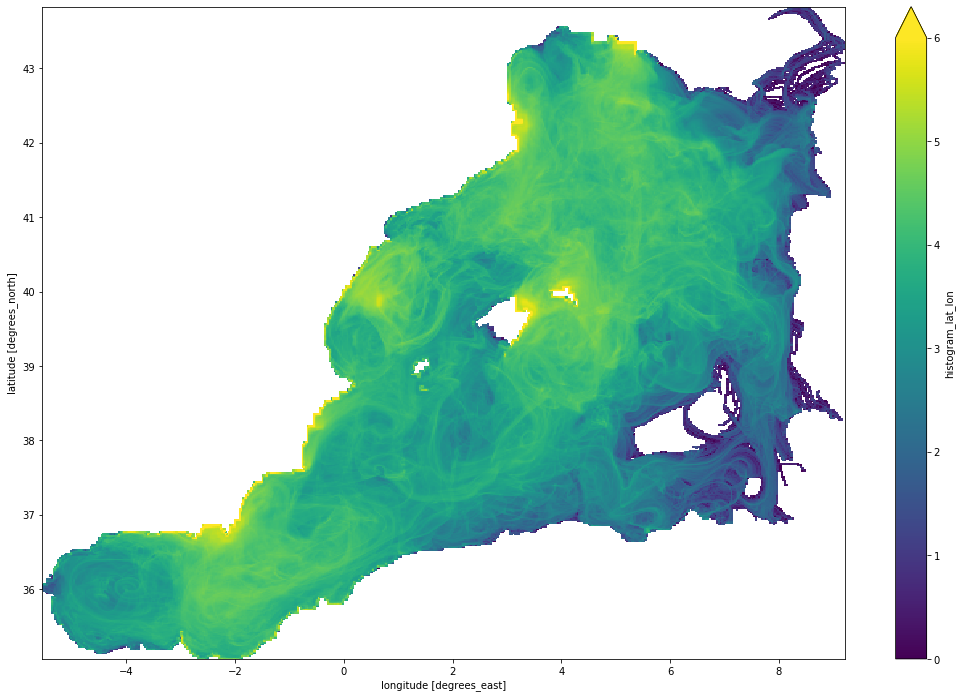

In [17]:
xr.ufuncs.log10(hist_lat_lon_stokes).plot(size=12, cmap="viridis", vmin=0, vmax=6);

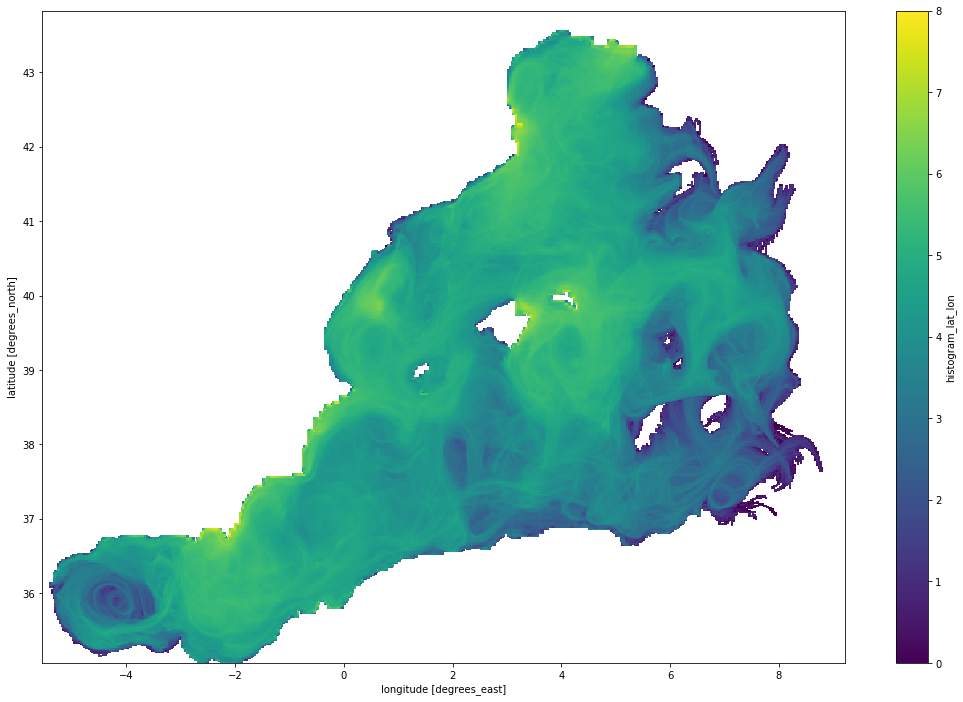

In [18]:
xr.ufuncs.log10(hist_lat_lon_nostokes).plot(size=12, cmap="viridis", vmin=0, vmax=8);

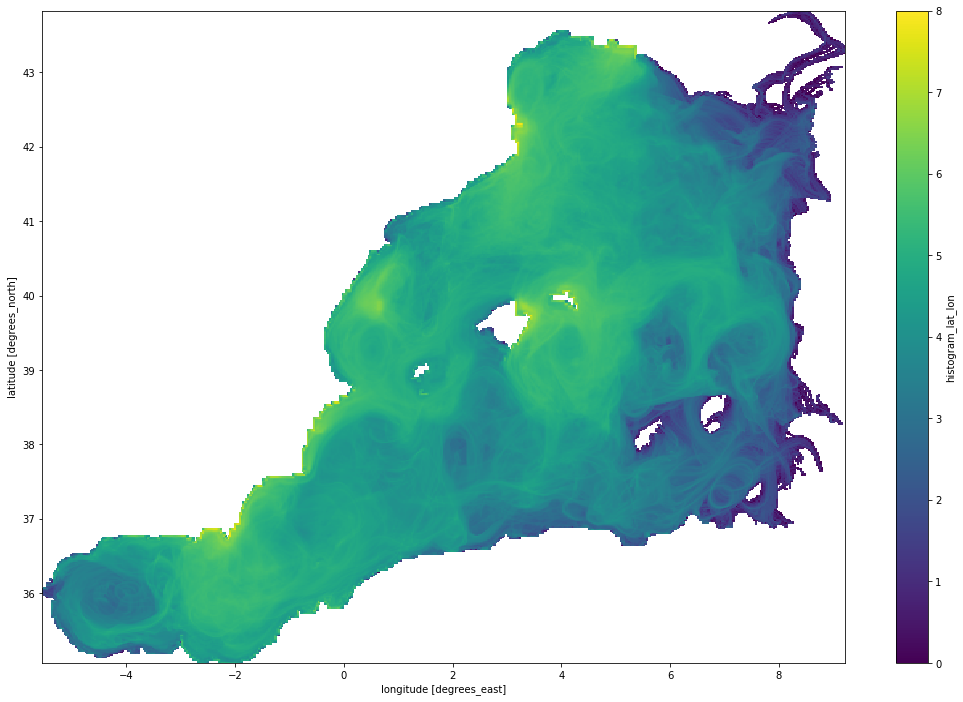

In [19]:
xr.ufuncs.log10(hist_lat_lon_combined).plot(size=12, cmap="viridis", vmin=0, vmax=8);

## Do something with the data before calculating histograms

We have a tracer measuring how big the influence of land was on the particle. (open ocean: `land==0`, on shore: `land==1`, in between: `land in [0, 1]`)  Here, we'll only use trajectories that never had any `land>0`.

In [20]:
ds_never_touches_land = ds_combined.where(ds_combined.land.sum("obs") == 0)
ds_never_touches_land

<xarray.Dataset>
Dimensions:   (obs: 962, traj: 15814080)
Dimensions without coordinates: obs, traj
Data variables:
    MPA       (traj, obs) float32 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
    distance  (traj, obs) float32 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
    land      (traj, obs) float32 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
    lat       (traj, obs) float32 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
    lon       (traj, obs) float32 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
    temp      (traj, obs) float32 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
    time      (traj, obs) float64 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
    z         (traj, obs) float32 dask.array<shape=(15814080, 962), chunksize=(100000, 962)>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Traject

In [21]:
hist_lat_lon_never_touches_land = xhist(
    ds_never_touches_land.lat,
    ds_never_touches_land.lon,
    bins=[lat_bins, lon_bins],
    dim=["traj", "obs"]
).persist(retries=20)

In [22]:
hist_lat_lon_never_touches_land

<xarray.DataArray 'histogram_lat_lon' (lat_bin: 500, lon_bin: 500)>
dask.array<shape=(500, 500), dtype=int64, chunksize=(500, 500)>
Coordinates:
  * lat_bin  (lat_bin) float64 35.07 35.09 35.11 35.12 ... 43.79 43.8 43.82
  * lon_bin  (lon_bin) float64 -5.541 -5.511 -5.482 -5.452 ... 9.15 9.18 9.209

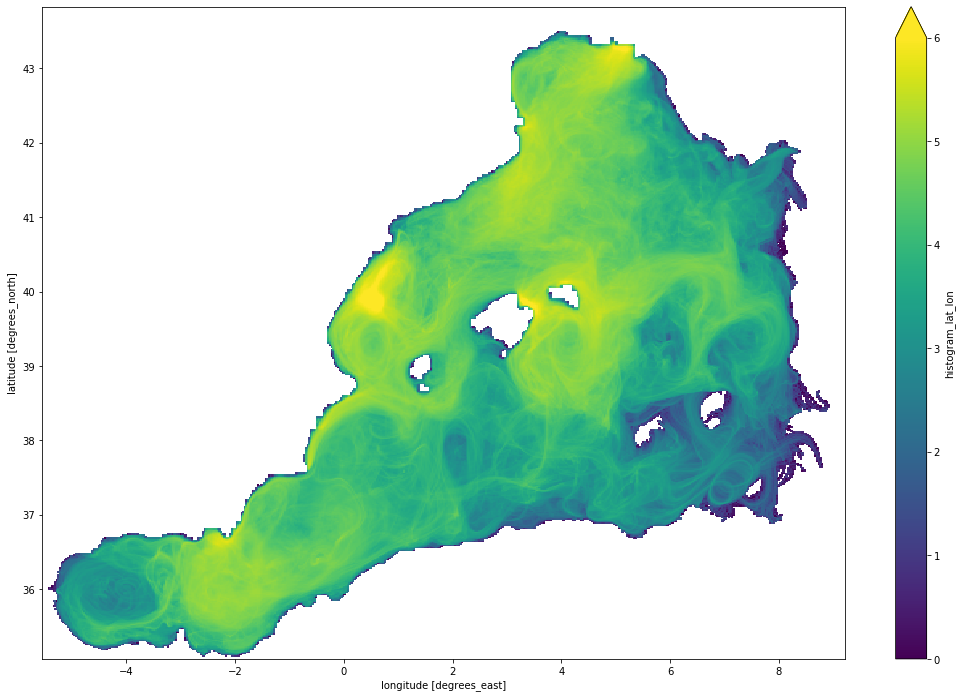

In [23]:
xr.ufuncs.log10(hist_lat_lon_never_touches_land).plot(size=12, cmap="viridis", vmin=0, vmax=6);

# Technical documentation

Lists the whole working environment.

In [24]:
%pip list

Package                 Version    
----------------------- -----------
absl-py                 0.8.0      
adal                    1.2.2      
affine                  2.2.2      
aiohttp                 3.5.4      
alembic                 1.1.0      
altair                  3.2.0      
antlr4-python3-runtime  4.7.2      
appdirs                 1.4.3      
asciitree               0.3.3      
asn1crypto              0.24.0     
astor                   0.7.1      
async-generator         1.10       
async-timeout           3.0.1      
attrdict                2.0.1      
attrs                   19.1.0     
backcall                0.1.0      
basemap                 1.2.1      
beautifulsoup4          4.8.0      
bleach                  3.1.0      
blinker                 1.4        
blosc                   1.8.1      
bokeh                   1.3.4      
boto3                   1.9.221    
botocore                1.12.221   
branca                  0.3.1      
cached-property         1.5.

In [25]:
%conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
@EXPLICIT
https://repo.anaconda.com/pkgs/main/linux-64/_libgcc_mutex-0.1-main.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ca-certificates-2019.6.16-hecc5488_0.tar.bz2
https://repo.anaconda.com/pkgs/main/linux-64/libgfortran-ng-7.3.0-hdf63c60_0.conda
https://repo.anaconda.com/pkgs/main/linux-64/libstdcxx-ng-9.1.0-hdf63c60_0.conda
https://conda.anaconda.org/conda-forge/linux-64/mpi-1.0-mpich.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/pandoc-2.7.3-0.tar.bz2
https://conda.anaconda.org/conda-forge/noarch/poppler-data-0.4.9-1.tar.bz2
https://repo.anaconda.com/pkgs/main/linux-64/toolchain-2.4.0-0.tar.bz2
https://repo.anaconda.com/pkgs/main/linux-64/libgcc-ng-9.1.0-hdf63c60_0.conda
https://conda.anaconda.org/conda-forge/linux-64/tbb-2018.0.5-h2d50403_0.tar.bz2
https://repo.anaconda.com/pkgs/main/linux-64/toolchain_c_linux-64-2.4.0-0.tar.bz2
http